## Weight initialization

Here, we will ...
* Investigage the importance of proper weight initialization technique to achieve desired performance of the deep learning algorithms.
* Use an example dataset: Fashion MNIST from torchvision package.
* Investigate eight (8) methods of initialization of the weights in the deep learning model.
  * Weight initialize with ...
    * All zeros
    * All ones
    * Uniform distribution, U ~ (0, 1)
    * Uniform distribution, U ~ (-0.5, 0.5)
    * Uniform distribution, U ~ (-y, y), where, y = sqrt( 1/ number of input features in the given layer )
    * Normal distribution, N ~ (0, 1)
    * Normal distribution, N ~ (0, y), where, y = sqrt( 1/ number of input features in the given layer )
    * Normal distribution, N ~ (0, y), where, y = sqrt( 1/ number of input and ouput features in the given layer )


### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [2]:
def dataloader(batch_size=100):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
    # Train and validation data
    trainset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True, 
                                     train=True, transform=transform)
    validset = datasets.FashionMNIST('~/.pytorch/FashionMNIST_data/', download=True,
                                     train=False, transform=transform)
    # Loaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    
    return trainloader, validloader

trainloader, validloader = dataloader(batch_size=512)

### Training and validation function
This function can be considered as a helper function.

In [3]:
def train(model, trainloader, validloader, n_epochs=1):
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Send model to GPU/CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Training
    batch_loss = []
    for iepoch in range(n_epochs):
        for ibatch, (images, labels) in enumerate(trainloader):
            
            progress = (ibatch+1)/len(trainloader) * 100
            sys.stdout.write('\rEpoch {}/{} ... Progress: {:0.2f} %'.format(iepoch+1, n_epochs, progress))
            sys.stdout.flush()
            
            # Data to GPU/CPU
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() # Set gradient to zero
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Loss
            loss.backward() # Backpropagation
            optimizer.step() # Update
            # Batch loss
            batch_loss.append(loss.item())
            
    # Validation accuracy
    valid_accuracy = 0
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        model.eval() # Turn off train mode
        # Predictions
        with torch.no_grad():
            output = model(images)
        output = output.argmax(dim=1)
        output = output.view(*labels.shape)
        equals = (output == labels).float()
        valid_accuracy += torch.mean(equals)
        # Turn on train mode
        model.train()
    valid_accuracy = valid_accuracy/len(validloader)
    
    return batch_loss, valid_accuracy

### Model
Define a simple model with 3 fully connected layers. Apply dropout with a probability of 20% to avoid overfitting.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

### Initialization methods

In [56]:
def init_weight_all_zeros(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)
#         
def init_weight_all_ones(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.fill_(1)
        m.bias.data.fill_(0)
#         
def init_weight_uniform(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0,1)
        m.bias.data.fill_(0)
#         
def init_weight_uniform_center(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(-0.5,0.5)
        m.bias.data.fill_(0)
#         
def init_weight_uniform_center_units(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n_in = m.in_features
        m.weight.data.uniform_(-1/np.sqrt(n_in), 1/np.sqrt(n_in))
        m.bias.data.fill_(0)
#         
def init_weight_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        std = 1
        m.weight.data.uniform_(0, std)
        m.bias.data.fill_(0)
#         
def init_weight_normal_units(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n_in = m.in_features
        std = np.sqrt(1 / n_in)
        m.weight.data.uniform_(0, std)
        m.bias.data.fill_(0)
#         
def init_weight_normal_units2(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n_in = m.in_features
        n_out = m.out_features
        std = np.sqrt(2 / (n_in + n_out))
        m.weight.data.uniform_(0, std)
        m.bias.data.fill_(0)
#         
init_methods = [init_weight_all_zeros, init_weight_all_ones,
                init_weight_uniform, init_weight_uniform_center, init_weight_uniform_center_units,
                init_weight_normal, init_weight_normal_units, init_weight_normal_units2]

### Train model separately with each of initialization methods

In [64]:
def train_with_each_method(init_methods, model, trainloader, validloader, n_epochs=2):
    losses = {}
    accuracies = {}
    for i, init_method in enumerate(init_methods):
        # Display method name
        method = str(init_method).split(' ')[1][12:].capitalize()
        print('\nInitialization method: {}...'.format(method))
        # Train model
        model = Net()
        model.apply(init_method)
        batch_loss, valid_accuracy = train(model, trainloader, validloader, n_epochs)
        # Accumulate losses and accuracies
        losses[method] = batch_loss
        accuracies[method] = np.round(valid_accuracy.to('cpu').numpy()*100, 2)
        
    return losses, accuracies

losses, accuracies = train_with_each_method(init_methods, model, trainloader, validloader, n_epochs=2)


Initialization method: All_zeros...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: All_ones...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: Uniform...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: Uniform_center...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: Uniform_center_units...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: Normal...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: Normal_units...
Epoch 2/2 ... Progress: 100.00 %
Initialization method: Normal_units2...
Epoch 2/2 ... Progress: 100.00 %

### Plots

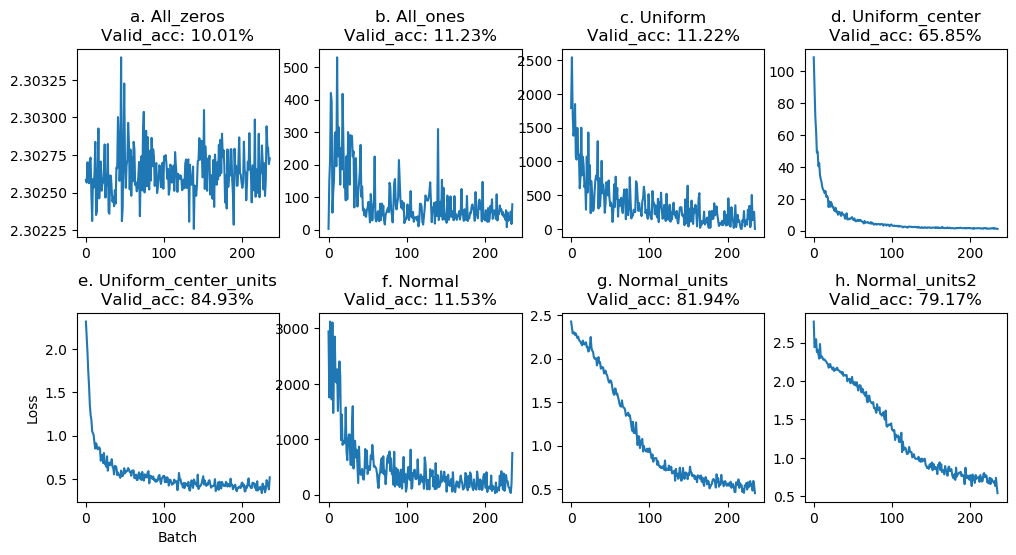

In [73]:
import string
letters = string.ascii_lowercase

fig, ax = plt.subplots(2,4, figsize=(12,6), dpi=100)
for i, init_method in enumerate(losses.keys()):   
    row = i // ax.shape[1]
    col = i % ax.shape[1]
    ax[row,col].plot(losses[init_method])
    ax[row,col].set_title( letters[i]+'. ' + init_method + '\nValid_acc: ' + str(accuracies[init_method]) + '%' )
ax[1,0].set_xlabel('Batch')
ax[1,0].set_ylabel('Loss')
plt.subplots_adjust(hspace=0.4)
plt.show()

Initialization methods that take the number of input and output features (panel e, g, h) provide better performance in the sense of convergence and validation accuracy.